In [1]:
!nvidia-smi


Fri Nov  7 09:57:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install opencv-python albumentations tqdm plotly seaborn


In [3]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [6]:
src_dir = '/content/drive/MyDrive/EcoVision_Final/images/images'
target_dir = '/content/drive/MyDrive/EcoVision_Final/data'



In [7]:
import os, shutil, random, pathlib
labels_map = {
    # Eco-friendly
    'aluminum_food_cans': 'eco',
    'aluminum_soda_cans': 'eco',
    'aerosol_cans': 'eco',
    'steel_food_cans': 'eco',
    'cardboard_boxes': 'eco',
    'cardboard_packaging': 'eco',
    'magazines': 'eco',
    'newspaper': 'eco',
    'office_paper': 'eco',
    'glass_beverage_bottles': 'eco',
    'glass_cosmetic_containers': 'eco',
    'glass_food_jars': 'eco',
    'coffee_grounds': 'eco',
    'eggshells': 'eco',
    'food_waste': 'eco',
    'tea_bags': 'eco',

    # Non-eco
    'disposable_plastic_cutlery': 'non_eco',
    'plastic_bags': 'non_eco',
    'plastic_water_bottles': 'non_eco',
    'plastic_soda_bottles': 'non_eco',
    'plastic_detergent_bottles': 'non_eco',
    'plastic_food_containers': 'non_eco',
    'plastic_shopping_bags': 'non_eco',
    'plastic_straws': 'non_eco',
    'plastic_trash_bags': 'non_eco',
    'plastic_cup_lids': 'non_eco',
    'styrofoam_cups': 'non_eco',
    'paper_cups': 'non_eco',
    'shoes': 'non_eco'
}



In [ ]:
import os, shutil, random, pathlib
#  Create train/val/test directories
splits = ['train', 'val', 'test']
for split in splits:
    for lbl in ['eco', 'non_eco']:
        os.makedirs(os.path.join(target_dir, split, lbl), exist_ok=True)

#  Copy images into train, val, test folders
for folder in os.listdir(src_dir):
    folder_path = os.path.join(src_dir, folder)
    if folder not in labels_map or not os.path.isdir(folder_path):
        print(f" Skipping unmatched folder: {folder}")
        continue
    mapped_label = labels_map[folder]
    images = list(pathlib.Path(folder_path).rglob('*.jpg')) \
           + list(pathlib.Path(folder_path).rglob('*.jpeg')) \
           + list(pathlib.Path(folder_path).rglob('*.png'))
    if not images:
        print(f" No images found in: {folder}")
        continue
    random.shuffle(images)
    n = len(images)
    train_end, val_end = int(0.8 * n), int(0.9 * n)
    for i, img_path in enumerate(images):
        split = 'train' if i < train_end else 'val' if i < val_end else 'test'
        shutil.copy(str(img_path), os.path.join(target_dir, split, mapped_label, os.path.basename(img_path)))
    print(f" Copied {n} images from {folder} → {mapped_label}")

print("\n Copy complete — dataset ready at:", target_dir)




 Copied 500 images from cardboard_packaging → eco
 Skipping unmatched folder: clothing
 Copied 500 images from aluminum_food_cans → eco
 Copied 500 images from aerosol_cans → eco


--------

In [8]:
for split in ['train', 'val', 'test']:
    eco_count = len(os.listdir(f"/content/drive/MyDrive/EcoVision_Final/data/{split}/eco"))
    non_eco_count = len(os.listdir(f"/content/drive/MyDrive/EcoVision_Final/data/{split}/non_eco"))
    print(f"{split.upper():<6} | eco: {eco_count:>4}  | non_eco: {non_eco_count:>4}  | total: {eco_count + non_eco_count}")


TRAIN  | eco:  251  | non_eco:  250  | total: 501
VAL    | eco:  248  | non_eco:  232  | total: 480
TEST   | eco:  246  | non_eco:  232  | total: 478


day 3

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/EcoVision_Final/data/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary')

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/EcoVision_Final/data/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary')

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/EcoVision_Final/data/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

print(" Data ready for training!")


Found 501 files belonging to 2 classes.
Found 480 files belonging to 2 classes.
Found 478 files belonging to 2 classes.
✅ Data ready for training!


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base layers

model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 295s 17s/step - accuracy: 0.7682 - loss: 0.4171 - val_accuracy: 0.6271 - val_loss: 1.1251
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.9745 - loss: 0.0502 - val_accuracy: 0.6875 - val_loss: 0.9521
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.9937 - loss: 0.0273 - val_accuracy: 0.6958 - val_loss: 1.0077
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.9935 - loss: 0.0186 - val_accuracy: 0.6792 - val_loss: 1.4111
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.9994 - loss: 0.0058 - val_accuracy: 0.7021 - val_loss: 1.1012


In [12]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False  # keep most layers frozen

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9711 - loss: 0.0670 - val_accuracy: 0.7042 - val_loss: 1.1688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - accuracy: 0.9875 - loss: 0.0570 - val_accuracy: 0.7021 - val_loss: 1.2059
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.9829 - loss: 0.0451 - val_accuracy: 0.6979 - val_loss: 1.2135
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.9970 - loss: 0.0217 - val_accuracy: 0.6938 - val_loss: 1.2326
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.9905 - loss: 0.0247 - val_accuracy: 0.6938 - val_loss: 1.2530
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.9961 - loss: 0.0150 - val_accuracy: 0.6917 - val_loss: 1.2791
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.6875 - val_loss: 1.3032
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.9907 - loss: 0.0270 - val_accuracy: 0.68

In [26]:
from tensorflow.keras import layers, models
import tensorflow as tf

#  Data Augmentation — adds visual variety
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

#  Fine-tuning setup
base_model.trainable = True
for layer in base_model.layers[:-10]:  # unfreeze top 10 layers
    layer.trainable = False

#  New model with regularization
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

#  Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#  Early Stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

#  Train (Step 10)
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[callback]
)



Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 465ms/step - accuracy: 0.5875 - loss: 0.9290 - val_accuracy: 0.6438 - val_loss: 0.8683
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.8568 - loss: 0.6499 - val_accuracy: 0.6521 - val_loss: 0.8846
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 479ms/step - accuracy: 0.9469 - loss: 0.4937 - val_accuracy: 0.6458 - val_loss: 0.9497
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9486 - loss: 0.4294 - val_accuracy: 0.6458 - val_loss: 1.0235


In [28]:
model.save('/content/drive/MyDrive/EcoVision_Final/mobilenet_final_v1.keras')

print("Model saved successfully to Drive!")


Model saved successfully to Drive!


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print(" Classification Report:\n", classification_report(y_true, y_pred, target_names=['non_eco', 'eco']))
print(" Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step
 Classification Report:
               precision    recall  f1-score   support

     non_eco       0.63      0.78      0.70       246
         eco       0.69      0.52      0.59       232

    accuracy                           0.65       478
   macro avg       0.66      0.65      0.64       478
weighted avg       0.66      0.65      0.65       478

 Confusion Matrix:
 [[192  54]
 [112 120]]


EcoVision Grad-CAM

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2


In [31]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [34]:
img_path = img_path = '/content/drive/MyDrive/EcoVision_Final/data/test/eco/Image_100.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


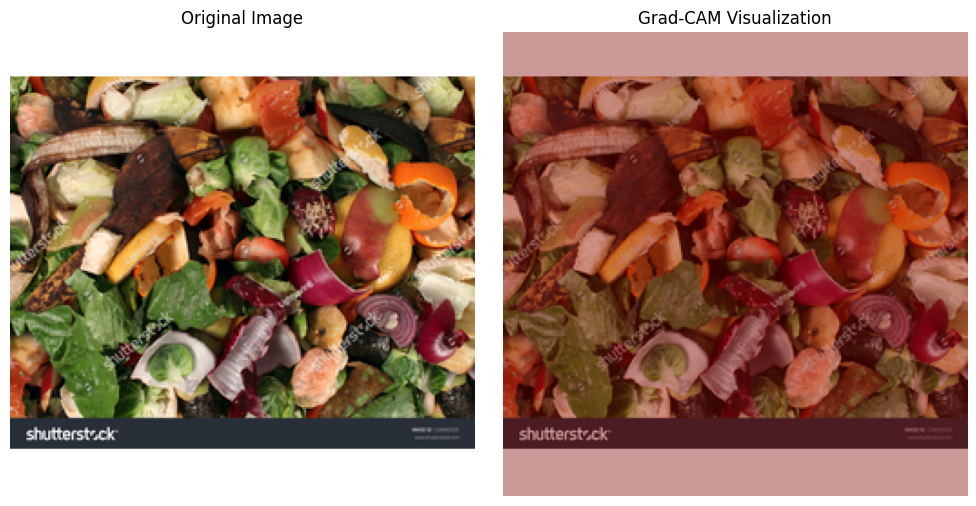

In [49]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

#  Load your final trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/EcoVision_Final/mobilenet_final_v1.keras')

#  Choose your test image (eco or non-eco)
img_path = '/content/drive/MyDrive/EcoVision_Final/data/test/eco/Image_100.png'

#  Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

#  Access the internal MobileNetV2
mobilenet_model = model.get_layer('mobilenetv2_1.00_224')
last_conv_layer = mobilenet_model.get_layer('Conv_1')

#  Extract only the "tail" layers
gap_layer = model.get_layer('global_average_pooling2d_9')
dropout_layer = model.get_layer('dropout_8')
dense_1 = model.get_layer('dense_18')
dense_2 = model.get_layer('dense_19')

#  Define how to apply the tail manually
def tail_forward(x):
    x = gap_layer(x)
    x = dropout_layer(x)
    x = dense_1(x)
    x = dense_2(x)
    return x

#  Build Grad-CAM model
grad_model = Model(
    inputs=mobilenet_model.input,
    outputs=[last_conv_layer.output, tail_forward(mobilenet_model.output)]
)

#  Forward pass to initialize
_ = grad_model(img_array)

#  Compute Grad-CAM heatmap
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    pred_index = tf.argmax(predictions[0])
    class_channel = predictions[:, pred_index]

grads = tape.gradient(class_channel, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Overlay Grad-CAM heatmap on original image
img_original = cv2.imread(img_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
heatmap_resized = cv2.resize(heatmap.numpy(), (img_original.shape[1], img_original.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap_color, 0.4, 0)

# Display both images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img_original)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM Visualization")
plt.imshow(superimposed_img)
plt.axis("off")
plt.tight_layout()
plt.show()


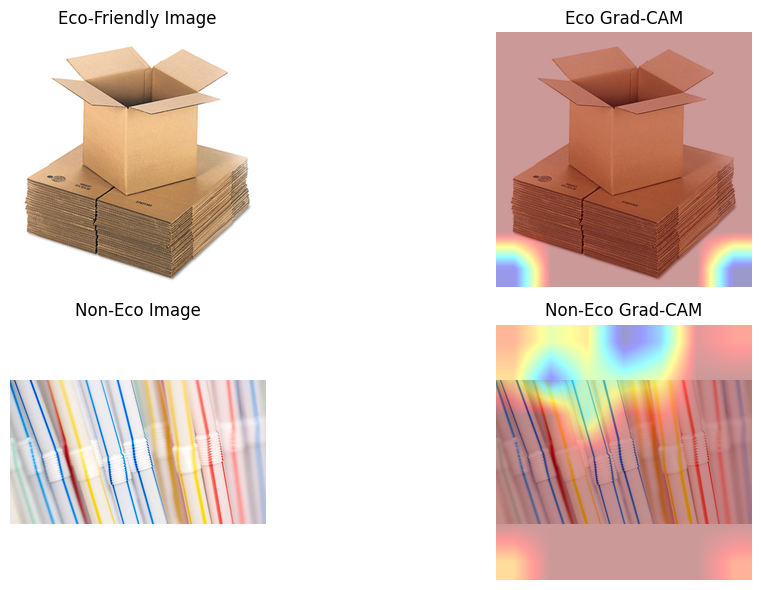

In [50]:
import os
import random
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Helper to generate Grad-CAM for any image path
def generate_gradcam(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(image.img_to_array(img), axis=0)

    mobilenet_model = model.get_layer('mobilenetv2_1.00_224')
    last_conv_layer = mobilenet_model.get_layer('Conv_1')

    gap_layer = model.get_layer('global_average_pooling2d_9')
    dropout_layer = model.get_layer('dropout_8')
    dense_1 = model.get_layer('dense_18')
    dense_2 = model.get_layer('dense_19')

    def tail_forward(x):
        x = gap_layer(x)
        x = dropout_layer(x)
        x = dense_1(x)
        x = dense_2(x)
        return x

    grad_model = Model(
        inputs=mobilenet_model.input,
        outputs=[last_conv_layer.output, tail_forward(mobilenet_model.output)]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    img_original = cv2.imread(img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap.numpy(), (img_original.shape[1], img_original.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap_color, 0.4, 0)
    return img_original, superimposed_img

# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/EcoVision_Final/mobilenet_final_v1.keras')

# Pick one random eco and non-eco image
eco_folder = '/content/drive/MyDrive/EcoVision_Final/data/test/eco'
non_eco_folder = '/content/drive/MyDrive/EcoVision_Final/data/test/non_eco'
eco_img = os.path.join(eco_folder, random.choice(os.listdir(eco_folder)))
non_eco_img = os.path.join(non_eco_folder, random.choice(os.listdir(non_eco_folder)))

# Generate Grad-CAMs
eco_orig, eco_heat = generate_gradcam(eco_img, model)
non_orig, non_heat = generate_gradcam(non_eco_img, model)

# Plot all together
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
plt.title("Eco-Friendly Image")
plt.imshow(eco_orig)
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Eco Grad-CAM")
plt.imshow(eco_heat)
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Non-Eco Image")
plt.imshow(non_orig)
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Non-Eco Grad-CAM")
plt.imshow(non_heat)
plt.axis("off")

plt.tight_layout()
plt.show()
